# Análisis de Inventario y Nivel de Servicio – Filtros DONSSON

Este análisis busca estimar el inventario ideal para cada referencia (SKU) de filtros, utilizando datos históricos de ventas mensuales y costo unitario. Además, se propone un modelo de cálculo con sus respectivos supuestos, se analiza el nivel de servicio alcanzado y se presentan insights visuales clave para la toma de decisiones.


### Carga de datos y primeras inspecciones

In [2]:
import pandas as pd   # manipulatcion y analisis de dataframes
import numpy as np  # operaciones matematicas y logicas
import matplotlib.pyplot as plt  # visualizacion de datos
import seaborn as sns # visualizacion de datos estadisticos
from scipy.stats import norm # distribuciones de probabilidad y estadistica

In [3]:
inventario = pd.read_excel('dataset/Ejercicio Análisis de Inventario y Nivel de Servicio.xlsx')

In [4]:
inventario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4770 entries, 0 to 4769
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Producto        4770 non-null   object 
 1   Enero           4770 non-null   int64  
 2   Febrero         4770 non-null   int64  
 3   Marzo           4770 non-null   int64  
 4   Abril           4770 non-null   int64  
 5   Mayo            4770 non-null   int64  
 6   Junio           4770 non-null   int64  
 7   Julio           4770 non-null   int64  
 8   Agosto          4770 non-null   int64  
 9   Septiembre      4770 non-null   int64  
 10  Octubre         4770 non-null   int64  
 11  Noviembre       4770 non-null   int64  
 12  Diciembre       4770 non-null   int64  
 13  Costo unitario  4770 non-null   float64
dtypes: float64(1), int64(12), object(1)
memory usage: 521.8+ KB


In [5]:
inventario.head()

,Producto,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre,Costo unitario
0,DAC00238020,0,0,0,0,0,0,0,0,0,0,0,0,1.0
1,DAC00237020,0,0,0,0,0,0,0,0,0,0,0,0,1.0
2,DAC00236020,0,0,0,0,0,0,0,0,0,0,0,0,1.0
3,DAX00416189,0,0,0,0,0,0,0,0,0,0,0,0,1.0
4,DAX00415189,0,0,0,0,0,0,0,0,0,0,0,0,1.0


### Analisis exploratorio EDA

#### Buenas practicas manejo de titulos de las columnas

In [6]:
columnas_nuevas =[]
for columnas in inventario.columns:
    minuscula = columnas.lower()
    strip = minuscula.strip()
    replace = minuscula.replace(" ","_")
    columnas_nuevas.append(replace)

inventario.columns = columnas_nuevas


#### Duplicados y nulos

In [7]:
print(f"Las dimensiones del dataframe son :{inventario.shape}")
print(f"Tiene las siguientes columnas :{inventario.columns}")

Las dimensiones del dataframe son :(4770, 14)
Tiene las siguientes columnas :Index(['producto', 'enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio',
       'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre',
       'costo_unitario'],
      dtype='object')


In [8]:
inventario.isnull().sum()

producto          0
enero             0
febrero           0
marzo             0
abril             0
mayo              0
junio             0
julio             0
agosto            0
septiembre        0
octubre           0
noviembre         0
diciembre         0
costo_unitario    0
dtype: int64

In [9]:
inventario.duplicated().sum()

np.int64(0)

In [10]:
inventario['producto'].duplicated().sum()

np.int64(0)

Se confirma la no existencia de valores duplicados o valores nulos , por filas no hay en general.Se evalua tambien por codigo de productos.

#### Componente estadistico

In [11]:
inventario.describe().T

,count,mean,std,min,25%,50%,75%,max
enero,4770.0,10.156184,53.182308,-1.0,0.0000,0.00,1.000,1525.0
febrero,4770.0,11.501258,56.615552,-1.0,0.0000,0.00,2.000,1431.0
marzo,4770.0,9.208595,44.522648,-50.0,0.0000,0.00,1.000,934.0
abril,4770.0,12.180084,64.487733,-2.0,0.0000,0.00,2.000,2195.0
mayo,4770.0,10.189099,48.809697,-8.0,0.0000,0.00,2.000,1194.0
junio,4770.0,9.620335,45.980754,-2.0,0.0000,0.00,1.000,1077.0
julio,4770.0,10.649895,50.444835,-1.0,0.0000,0.00,2.000,1094.0
agosto,4770.0,11.148847,54.783009,-1.0,0.0000,0.00,2.000,1389.0
septiembre,4770.0,10.319078,50.419661,-1.0,0.0000,0.00,2.000,1107.0
octubre,4770.0,13.237526,78.706880,-12.0,0.0000,0.00,2.000,2797.0


Se identifica la existencia de cantidades de productos negativos :

Resalta el valor negativo existente el mes de marzo con -50 unidaes , igual manera destaca que en los meses de Octubre y Noviembre encontramos -12 unidades.

Posibles causas:

- Ajuste de invenatario con negativos
- Errores de digitacion
- Devoluciones de producto

Dado que no se explica como tratar estos valores con el fin de mantener calidad en los datos se decide que los valores negativos se reemplazaran por 0 dado que en la informacion suminstrada no habalan de devoluciones formales o ajustes.

In [12]:
meses = inventario.columns[1:13]
inventario[meses] =inventario[meses].clip(lower=0)
inventario.describe().T

,count,mean,std,min,25%,50%,75%,max
enero,4770.0,10.156394,53.182266,0.0,0.0000,0.00,1.000,1525.0
febrero,4770.0,11.502096,56.615374,0.0,0.0000,0.00,2.000,1431.0
marzo,4770.0,9.252411,44.493138,0.0,0.0000,0.00,1.000,934.0
abril,4770.0,12.181342,64.487479,0.0,0.0000,0.00,2.000,2195.0
mayo,4770.0,10.191405,48.809072,0.0,0.0000,0.00,2.000,1194.0
junio,4770.0,9.622013,45.980375,0.0,0.0000,0.00,1.000,1077.0
julio,4770.0,10.650524,50.444696,0.0,0.0000,0.00,2.000,1094.0
agosto,4770.0,11.149476,54.782875,0.0,0.0000,0.00,2.000,1389.0
septiembre,4770.0,10.320126,50.419436,0.0,0.0000,0.00,2.000,1107.0
octubre,4770.0,13.246122,78.704848,0.0,0.0000,0.00,2.000,2797.0


#### Verificacion codigo unico SKU

In [13]:
# Limpiar espacios en la columna "Producto"
inventario["producto"] = inventario["producto"].astype(str).str.strip()


In [14]:
inventario['producto'].sample(5)

930     DCX10355138
315     DAE09235025
1450    DCE00501115
1341    DCE20129138
548     DCE00479189
Name: producto, dtype: object

In [15]:
print(f"El inventario tiene {inventario['producto'].nunique()} productos distintos.")

El inventario tiene 4770 productos distintos.


In [16]:
import re

def es_sku_valido(sku):
    if isinstance(sku, str):
        sku = sku.strip().upper()
        longitud_valida = len(sku) == 11  
        tiene_letra = bool(re.search(r'[A-Z]', sku))
        tiene_numero = bool(re.search(r'\d', sku))
        palabras_invalidas = ["ACTIVO", "FIJO", "SERV", "ENERGIA", "VENTA", "FLETE", "MUESTRA", "INTERESES", "REVISIÓN", "HERRAMIENTA"]
        contiene_invalidas = any(p in sku for p in palabras_invalidas)
        
        return longitud_valida and tiene_letra and tiene_numero and not contiene_invalidas
    return False


In [17]:
inventario["SKU_valido"] = inventario["producto"].apply(es_sku_valido)
inventario = inventario[inventario["SKU_valido"] == True].copy()
print(f"Total después de limpieza: {len(inventario)}")
print("Se eliminarion 36 productos no válidos.")
print("Equivalente al 0.76% del total de productos.")

Total después de limpieza: 4734
Se eliminarion 36 productos no válidos.
Equivalente al 0.76% del total de productos.


In [18]:
inventario['producto'].sort_values()

1587    AC000001222
1588    AC000002222
4507    AC000005020
4494    AGB0CHAS021
981     AGB0GRAS030
           ...     
1567    RG010276222
1566    RG127102222
1565    RG133102222
3692    RM152178047
3691    RM152203047
Name: producto, Length: 4734, dtype: object

Se aplicó un filtro básico para eliminar referencias no técnicas o inválidas. Los criterios fueron:

- Eliminar espacios en blanco al inicio o final.
- Que no inicaran con letras y que no tuvieran números.
- Validar que el nombre contenga al menos un 11 caracteres, lo cual es típico de SKUs técnicos.

Este enfoque flexible conserva referencias válidas aún si no siguen una nomenclatura específica, pero excluye descripciones genéricas sin estructura numérica.


#### Creacion columna valor total

In [19]:
inventario["cantidad_vendidos"] = inventario.iloc[:, 1:13].sum(axis=1)
sin_ventas = inventario[inventario["cantidad_vendidos"] == 0]
print(f"{len(sin_ventas)} productos sin ventas en todo el año.")


2281 productos sin ventas en todo el año.


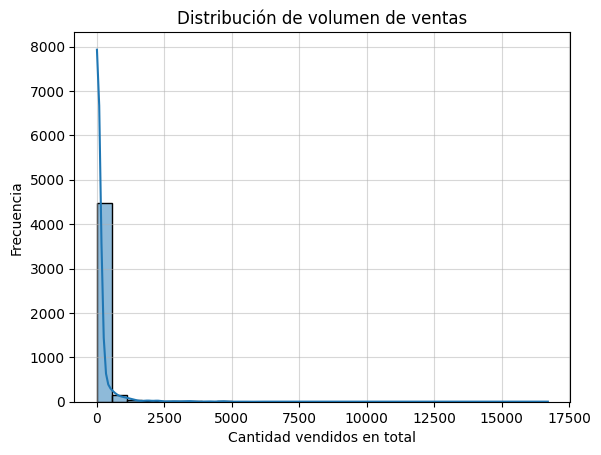

In [20]:
sns.histplot(inventario["cantidad_vendidos"], bins=30, kde=True)
plt.grid(True , alpha = 0.5)
plt.title("Distribución de volumen de ventas")
plt.xlabel("Cantidad vendidos en total")
plt.ylabel("Frecuencia")
plt.show()

In [21]:
inventario = inventario.drop(columns=(['SKU_valido']))
inventario.head()

,producto,enero,febrero,marzo,abril,mayo,junio,julio,agosto,septiembre,octubre,noviembre,diciembre,costo_unitario,cantidad_vendidos
0,DAC00238020,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0
1,DAC00237020,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0
2,DAC00236020,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0
3,DAX00416189,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0
4,DAX00415189,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0


Se proceden a eliminar aquellos productos que no han sido vendidos ni una vez a lo largo del año

In [22]:
inventario = inventario[inventario["cantidad_vendidos"] > 0].copy()
inventario["cantidad_vendidos"].sort_values(ascending=False).tail(5)

4509    1
4510    1
4577    1
4607    1
4504    1
Name: cantidad_vendidos, dtype: int64

Se identificaron 2281 productos que no registraron ventas en los últimos 12 meses. Estos casos fueron excluidos del modelo de inventario ideal, ya que no es posible estimar demanda o variabilidad.

Se recomienda a la empresa:

- Verificar si estos productos están descontinuados o inactivos.
- Considerar su eliminación del catálogo o mantener un inventario de seguridad mínimo si son estratégicos o de uso muy puntual.


#### Manejo de productos con enfoque al costo

Para este punto se realiza una investigacion de los precios de venta de la empresa, hay que tener en cuenta que este es el costo de venta que se encontro en la pagina y estamos trabajando con el costo de adquisicion:


 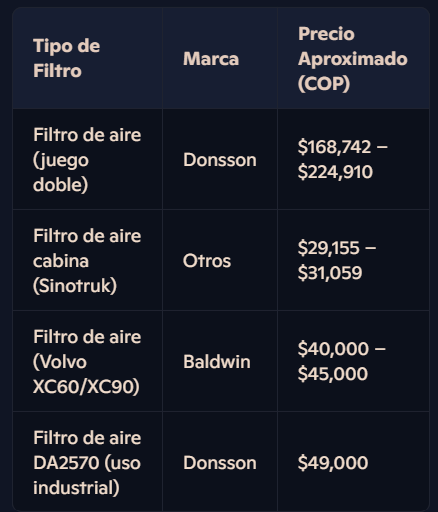

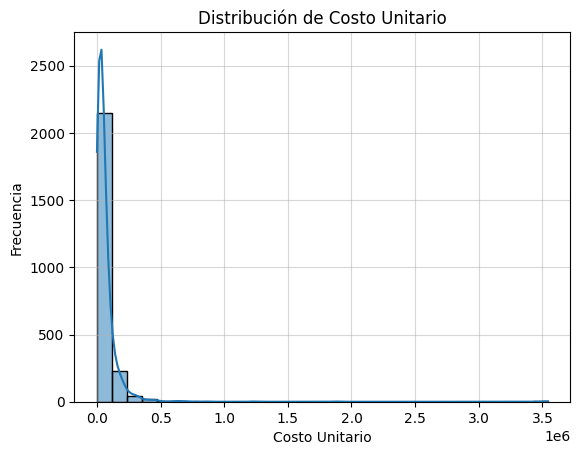

In [23]:
sns.histplot(inventario["costo_unitario"], bins=30, kde=True)
plt.grid(True , alpha = 0.5)
plt.title("Distribución de Costo Unitario")
plt.xlabel("Costo Unitario")
plt.ylabel("Frecuencia")
plt.show()

Se identifica una distribucion amplia en cuanto los costos existe una tendencia con costos unitarios entre 0 y 0.5 pero se extienden hasta 3.5 por tanto vamos a analizar el comportamiento de esta columna.

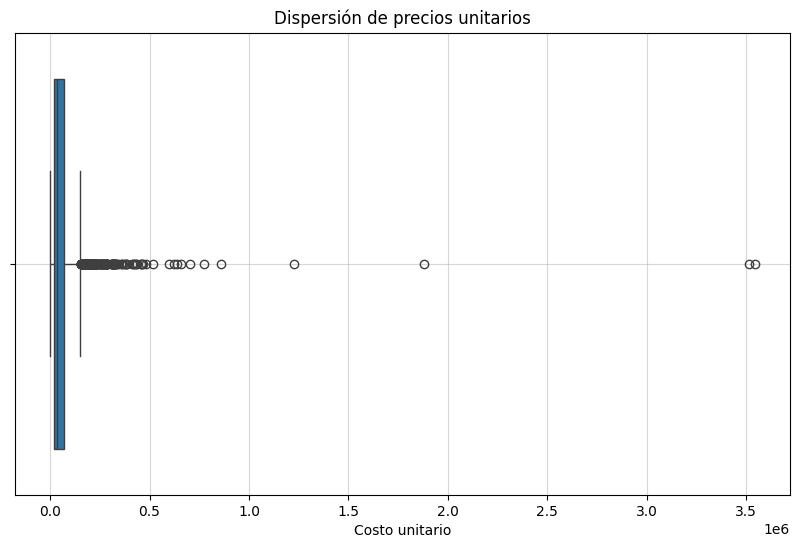

In [24]:
plt.figure(figsize=(10,6))
sns.boxplot(x=inventario["costo_unitario"])
plt.title("Dispersión de precios unitarios")
plt.xlabel("Costo unitario")
plt.grid(True, alpha=0.5)
plt.show()


Identificamos una distribucion con outliers muy marcados pero llama la atencion el costo unitario de los productos se va a cambiar el enfoque del estudio con el fin de comprender como se comporta esta variable.

In [25]:
inventario['costo_unitario'].describe()

count    2.453000e+03
mean     6.308420e+04
std      1.307003e+05
min      1.000000e+00
25%      1.828268e+04
50%      3.550827e+04
75%      7.204790e+04
max      3.542826e+06
Name: costo_unitario, dtype: float64

Llama especialmente la atencion que existan productos que valgan menos de 30 mil pesos dado el estudio de mercado que se realizo en el cual tenemos en cuenta un supuesto que el margen de utilidad es del 30%, por tanto cuando la media de los mismos es de 63 mil pesos y la moda en 35 mil pesos por tanto se van a analizar para una posible imputacion.

In [26]:
precio_venta_minimo= 25000
margen = 0.5
Costo_minimo_real = precio_venta_minimo * (1 - margen)
Costo_minimo_real


12500.0

In [27]:
print(f"Cantidad de productos con valor en debajo del esperado :{len(inventario[inventario['costo_unitario'] < Costo_minimo_real])}")
print(f"Total de productos {len(inventario['costo_unitario'])}")
print(f"El total porcentual de productos por debajo del valor esperado es de {((len(inventario[inventario['costo_unitario'] < Costo_minimo_real]) /len(inventario['costo_unitario']))*100):.0f}%")


Cantidad de productos con valor en debajo del esperado :416
Total de productos 2453
El total porcentual de productos por debajo del valor esperado es de 17%


Al ser un porcentaje tan alto de la informacion se decide clasificarlos por tanto se procede a generar una nueva columna , hay riesgo de contaminar la informacion y al ser un ejercicio en el cual no se puede preguntar en campo se opta por separarse .

Si el caso fuera real preguntaria y me instruiria para dividirlos por familia o tipo de producto con el fin de llegar a la causa raiz de esta desviacion.

In [28]:
inventario["costo_valido"] = np.where(inventario["costo_unitario"] >= 25000, "si", "no")


In [29]:
inventario.columns

Index(['producto', 'enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio',
       'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre',
       'costo_unitario', 'cantidad_vendidos', 'costo_valido'],
      dtype='object')

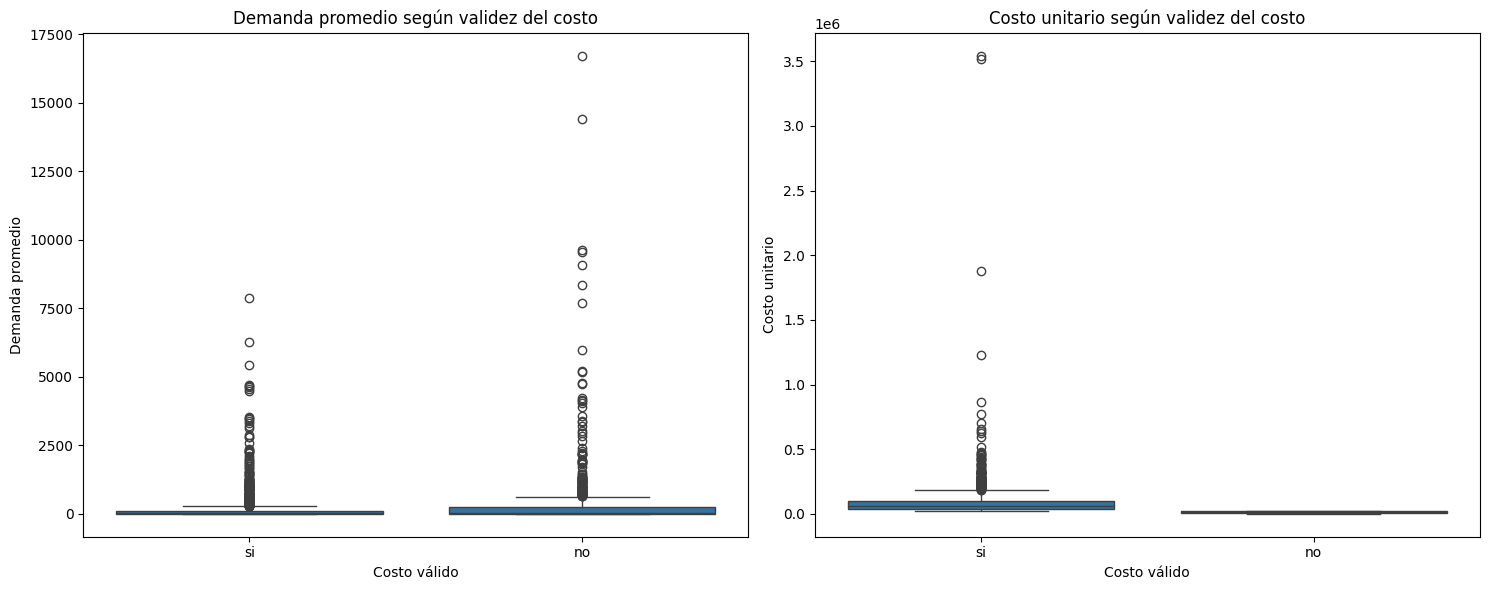

In [30]:
plt.figure(figsize=(15,6))
# Gráfico 1: Demanda promedio vs costo válido
plt.subplot(1, 2, 1)
sns.boxplot(data=inventario, x="costo_valido", y="cantidad_vendidos")
plt.title("Demanda promedio según validez del costo")
plt.xlabel("Costo válido")
plt.ylabel("Demanda promedio")

# Gráfico 2: Costo unitario vs costo válido
plt.subplot(1, 2, 2)
sns.boxplot(data=inventario, x="costo_valido", y="costo_unitario")
plt.title("Costo unitario según validez del costo")
plt.xlabel("Costo válido")
plt.ylabel("Costo unitario")

plt.tight_layout()
plt.show()


Los productos con costos inválidos no presentan diferencias significativas en su demanda respecto a los productos con costos válidos. Esto indica que algunos productos con valores sospechosos están en rotación activa y no deben eliminarse sin una revisión previa como ya se menciono se debe validar este tema.

En cambio, sí se observa una dispersión mucho menor en el costo unitario de los productos no válidos, lo cual confirma que esos valores son anómalos.

Se recomienda generar una lista priorizada de productos con alta demanda y costo inválido para validación comercial.


In [31]:
sospechosos = inventario[(inventario["costo_valido"] == "no") & (inventario["cantidad_vendidos"] > 100)]
sospechosos[["producto", "cantidad_vendidos", "costo_unitario"]]


,producto,cantidad_vendidos,costo_unitario
112,DCE10580190,391,10989.00
127,DCE00662186,198,8815.00
162,DCS00411189,556,9976.27
213,DAC00212020,111,11695.50
221,DWS00303189,200,17519.00
...,...,...,...
4347,DAR02031025,302,18641.68
4348,DAB02028025,1013,24852.06
4350,DAB02025025,144,24058.25
4353,DAB02021025,657,21002.87


In [32]:
inventario.head()

,producto,enero,febrero,marzo,abril,mayo,junio,julio,agosto,septiembre,octubre,noviembre,diciembre,costo_unitario,cantidad_vendidos,costo_valido
33,DAB28248025,0,0,0,0,0,0,0,0,0,0,0,24,105483.82,24,si
34,DAB28227025,0,0,0,0,0,0,0,0,0,0,0,36,105582.49,36,si
35,BAE00235125,0,0,0,0,0,0,0,0,0,0,0,3,66261.00,3,si
36,BAE09232125,0,0,0,0,0,0,0,0,0,0,0,2,78758.00,2,si
37,BCS00764125,0,0,0,0,0,0,0,0,0,0,0,4,129239.00,4,si


#### Analisis ventas totales

In [33]:
inventario["ventas_totales"] = inventario["cantidad_vendidos"] * inventario["costo_unitario"]


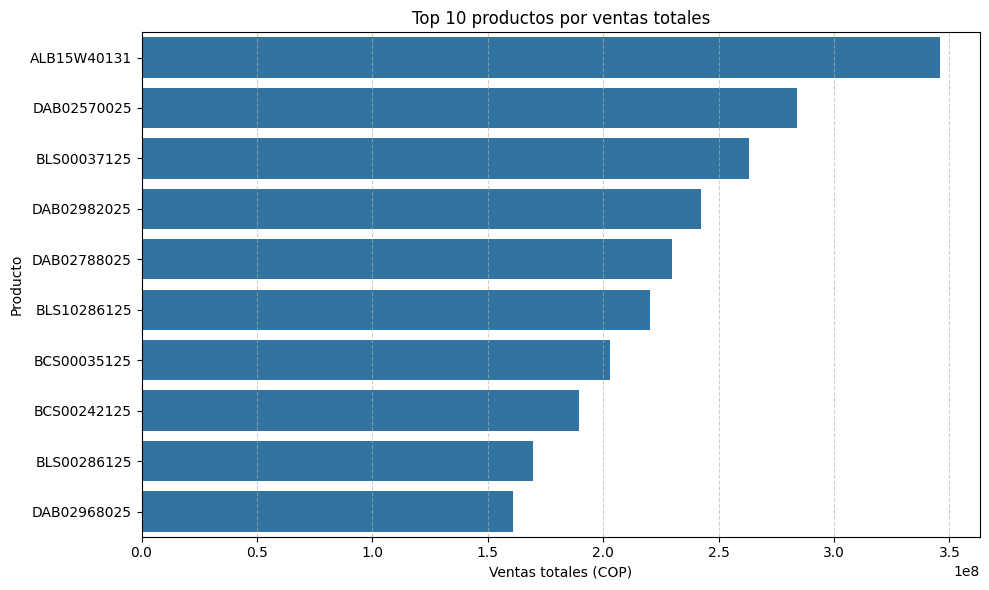

In [34]:
top_ventas = inventario.sort_values("ventas_totales", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_ventas,
    x="ventas_totales",
    y="producto"
)
plt.title("Top 10 productos por ventas totales")
plt.xlabel("Ventas totales (COP)")
plt.ylabel("Producto")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


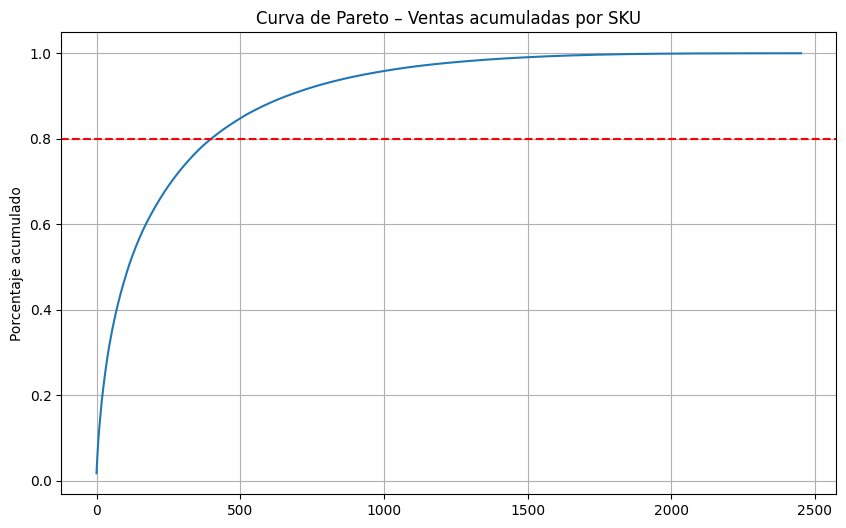

In [35]:
inventario_sorted = inventario.sort_values("ventas_totales", ascending=False)
inventario_sorted["acumulado"] = inventario_sorted["ventas_totales"].cumsum()
inventario_sorted["%_acumulado"] = inventario_sorted["acumulado"] / inventario_sorted["ventas_totales"].sum()

# Gráfico Pareto
plt.figure(figsize=(10,6))
sns.lineplot(data=inventario_sorted, x=range(len(inventario_sorted)), y="%_acumulado")
plt.axhline(0.8, color='red', linestyle='--')
plt.grid(True)
plt.title("Curva de Pareto – Ventas acumuladas por SKU")
plt.ylabel("Porcentaje acumulado")
plt.show()

In [36]:
#Identificar el número de productos que suman hasta el 80% de las ventas
productos_pareto = inventario_sorted[inventario_sorted["%_acumulado"] <= 0.80]
n_productos_pareto = productos_pareto.shape[0]
total_productos = inventario_sorted.shape[0]

#Calcular el porcentaje que representan
porcentaje_productos = round((n_productos_pareto / total_productos) * 100, 2)
print(f"{n_productos_pareto} productos generan el 80% de las ventas.")
print(f"Eso representa el {porcentaje_productos}% del total de productos")
print(f"Cantidad total de productos {len(inventario)}")



399 productos generan el 80% de las ventas.
Eso representa el 16.27% del total de productos
Cantidad total de productos 2453


La curva de Pareto muestra que el 80% de las ventas son generadas por aproximadamente el 16.27% de los productos, lo cual confirma que una **minoría del portafolio genera la mayoría del ingreso**.

Este hallazgo respalda la necesidad de **focalizar los recursos de planeación y stock en los productos de alto impacto**, mientras que los productos de baja rotación pueden gestionarse con políticas de inventario más flexibles o revisión periódica.


In [37]:
inventario.head(20)

,producto,enero,febrero,marzo,abril,mayo,junio,julio,agosto,septiembre,octubre,noviembre,diciembre,costo_unitario,cantidad_vendidos,costo_valido,ventas_totales
33,DAB28248025,0,0,0,0,0,0,0,0,0,0,0,24,105483.82,24,si,2531611.68
34,DAB28227025,0,0,0,0,0,0,0,0,0,0,0,36,105582.49,36,si,3800969.64
35,BAE00235125,0,0,0,0,0,0,0,0,0,0,0,3,66261.00,3,si,198783.00
36,BAE09232125,0,0,0,0,0,0,0,0,0,0,0,2,78758.00,2,si,157516.00
37,BCS00764125,0,0,0,0,0,0,0,0,0,0,0,4,129239.00,4,si,516956.00
46,DCS00680186,0,0,0,0,0,0,0,0,0,0,4,9,86219.00,13,si,1120847.00
47,DCX00390137,0,0,0,0,0,0,0,0,0,0,0,2,15463.00,2,no,30926.00
48,DLS00289137,0,0,0,0,0,0,0,0,0,0,0,5,107635.00,5,si,538175.00
49,DCS00759137,0,0,0,0,0,0,0,0,0,0,1,3,83193.00,4,si,332772.00
50,DCE00986137,0,0,0,0,0,0,0,0,0,0,0,11,35419.00,11,si,389609.00


### Archivo excel limpio de salida

In [38]:
inventario.to_excel('dataset/archivo_actualizado.xlsx')